In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from os.path import expanduser

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME, DATASET_JSON_PATH

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

/home/gautamsai_y/.conda/envs/rv-21/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Configuration

In [2]:
from experiment_configs.configs import *
config = test_config

### Create Rastervision datasets

In [3]:
from torch.utils.data import ConcatDataset
import json
from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, warn_if_nan_in_raw_raster
from utils.data_management import observation_factory

# get the current working directory
root_dir = os.getcwd()

# define the relative path to the dataset JSON file
json_rel_path = '../' + DATASET_JSON_PATH

# combine the root directory with the relative path
json_abs_path = os.path.join(root_dir, json_rel_path)

dataset_json = json.load(open(json_abs_path, 'r'))
all_observations = observation_factory(dataset_json)

training_scenes = []
validation_scenes = []

for observation in all_observations:

    if observation.cluster_id == 0: #statically assign clusetr zero to validation set
        validation_scenes.append(observation_to_scene(config, observation))
    else:
        training_scenes.append(observation_to_scene(config, observation))


training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes #random window sampling happens here
]
validation_datasets = [
    scene_to_validation_ds(config, scene) for scene in validation_scenes
]

train_dataset_merged = ConcatDataset(training_datasets[:10])
val_dataset_merged = ConcatDataset(validation_datasets[:10])


2023-11-21 10:31:19:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s2/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s2.tif.
2023-11-21 10:31:19:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s1/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s1.tif.
2023-11-21 10:31:19:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/annotations/Kathajodi_Cuttack_85-85_20-44_2022-05-01_annotations.geojson.
2023-11-21 10:31:19:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/rivers/Kathajodi_Cuttack_85-85_20-44_rivers_1000m.

## Visualize the datasets

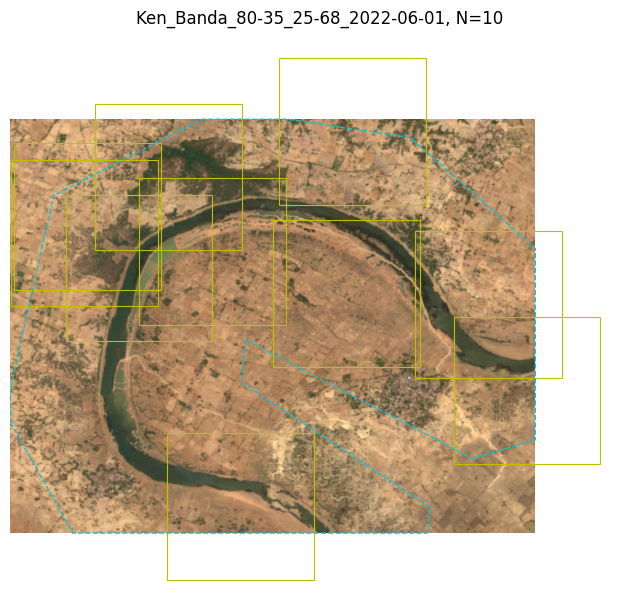

In [4]:
from utils.visualizing import visualize_dataset

# for ds in training_datasets:
#     visualize_dataset(ds)
visualize_dataset([training_datasets[0]])

# for ds in validation_datasets:
#     visualize_dataset(ds)

# Train

In [5]:
from models.model_factory import model_factory
from ml.optimizer_factory import optimizer_factory
from ml.learner import BinarySegmentationLearner

_, _, n_channels = training_datasets[0].scene.raster_source.shape
model = model_factory(
    config,
    n_channels=n_channels,
)

optimizer = optimizer_factory(config, model)

learner = BinarySegmentationLearner(
    config=config,
    model=model,
    optimizer=optimizer,
    train_ds=train_dataset_merged,  # for development and debugging, use training_datasets[0] or similar to speed up
    valid_ds=val_dataset_merged,  # for development and debugging, use training_datasets[1] or similar to speed up
    # output_dir=expanduser("~/sandmining-watch/out/OUTPUT_DIR"),
)

learner.log_data_stats()

2023-11-21 10:31:37:rastervision: INFO - train_ds: 100 items
2023-11-21 10:31:37:rastervision: INFO - valid_ds: 241 items


#### Check GPU Activity

You can continuously monitor your GPU activity by using the command in the terminal


`watch -d -n 0.5 nvidia-smi`

In [6]:
# Run this cell if you want to log the run to W&B. You might need to authenticate to W&B.
# learner.initialize_wandb_run()

In [8]:
learner.train(epochs=1)

2023-11-21 10:31:41:rastervision: INFO - epoch: 0


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-21 10:32:11:rastervision: INFO - metrics:
{'avg_f1': 0.9213616251945496,
 'avg_precision': 1.0,
 'avg_recall': 0.8541895747184753,
 'epoch': 0,
 'other_f1': 0.9213616251945496,
 'other_precision': 1.0,
 'other_recall': 0.8541895747184753,
 'sandmine_average_precision': tensor(nan, device='cuda:0'),
 'sandmine_f1': 0.0,
 'sandmine_precision': 0.0,
 'sandmine_recall': 0.0,
 'train_bce_loss': 0.006430175900459289,
 'train_dice_loss': 0.01,
 'train_time': datetime.timedelta(seconds=9, microseconds=708154),
 'val_bce_loss': tensor(0.0051, device='cuda:0'),
 'val_dice_loss': tensor(0.0083, device='cuda:0'),
 'valid_time': datetime.timedelta(seconds=20, microseconds=618936)}


## Evaluate 

Initialize evaluation_datasets and predictor.
evaluation_datasets and validation_datasets are based on identical scenes, but have different sliding window configurations.

In [10]:
from ml.learner import BinarySegmentationPredictor
from utils.rastervision_pipeline import scene_to_inference_ds

# evaluation_datasets =  [
#     scene_to_inference_ds(
#         config, scene, full_image=True
#     ) for scene in validation_scenes
# ]
evaluation_datasets = []
all_observations = observation_factory(dataset_json)
for observation in all_observations:
    if observation.cluster_id == 0: #statically assign clusetr zero to validation set
        evaluation_datasets.append(scene_to_inference_ds(config, observation_to_scene(config, observation, weights_class=False), full_image=True))

predictor = BinarySegmentationPredictor(
    config,
    model,
)

# # Alternatively: specify path to trained weights
# path_to_weights = expanduser("~/sandmining-watch/out/1102-satmae-1/last-model.pth")
# predictor = BinarySegmentationPredictor(
#     config,
#     model,
#     path_to_weights,
# )

2023-11-21 10:34:51:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s2/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s2.tif.
2023-11-21 10:34:51:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s1/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s1.tif.
2023-11-21 10:34:51:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/annotations/Kathajodi_Cuttack_85-85_20-44_2022-05-01_annotations.geojson.
2023-11-21 10:34:51:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/rivers/Kathajodi_Cuttack_85-85_20-44_rivers_1000m.

In [12]:
from ml.eval_utils import evaluate_predicitions, make_wandb_segmentation_masks, make_wandb_predicted_probs_images
from utils.visualizing import raster_source_to_rgb

prediction_results_list = []

for ds in evaluation_datasets[:1]:
    predictions = predictor.predict_mine_probability_for_site(ds)

    rgb_img = raster_source_to_rgb(ds.scene.raster_source)
    prediction_results_list.append({
        "predictions": predictions,
        "ground_truth": ds.scene.label_source.get_label_arr(),
        "rgb_img": rgb_img,
        "name": ds.scene.id
    })

evaluation_results_dict = evaluate_predicitions(prediction_results_list)

Log results to Weights & Biases

In [ ]:
import wandb

assert wandb.run is not None

# Add lists of W&B images to dict
evaluation_results_dict.update({
    'Segmenation masks': make_wandb_segmentation_masks(prediction_results_list),
    'Predicted probabilites': make_wandb_predicted_probs_images(prediction_results_list),
})

# Log to W&B
wandb.log(evaluation_results_dict)

In [ ]:
wandb.finish()